In [1]:
!nvidia-smi

Fri Apr 16 02:04:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   31C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import liabraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
import tensorflow as tf
from pathlib import Path


# Image Preprocessing (Create The dataset for TF)

In [23]:
image_size = (102, 102) 
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "splitted_data/train",
    labels = 'inferred',
#     label_mode='categorical',
    label_mode='int',
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "splitted_data/val",
    labels = 'inferred',
#     label_mode='categorical',
    label_mode='int',
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "splitted_data/test",
    labels = 'inferred',
#     label_mode='categorical',
    label_mode='int',
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)

Found 8000 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.


In [24]:
# The class names that is inferred from the folders names
class_names = train_ds.class_names
print(class_names)

['Boots', 'Sandals', 'Shoes', 'Slippers']


In [42]:
# Check the batch shape
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 102, 136, 3)
(32, 4)


In [26]:
# Configure and normalize the dataset for better performance

# AUTOTUNE = tf.data.AUTOTUNE
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=100)
train_ds = train_ds.map(lambda x, y: (norm_layer(x), y))   #  pixels values be in '[0,1]'

val_ds = val_ds.cache().prefetch(buffer_size=100)
val_ds = val_ds.map(lambda x, y: (norm_layer(x), y))  

test_ds = test_ds.cache().prefetch(buffer_size=100)
test_ds = test_ds.map(lambda x, y: (norm_layer(x), y))

# TRANSFER LEARNING

We choose to use Xception since it is the SoA model available on Keras. (https://keras.io/api/applications/)

In [53]:
from tensorflow.keras.applications import xception

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report


## 1- Only train the classifier

In [50]:
input_tensor = Input(shape=(102, 102, 3))
xception_model = xception.Xception(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling = 'avg')
# x = GlobalAveragePooling2D()(xception_model.output)
predictions = Dense(4, activation='softmax')(xception_model.output)

model = Model(inputs=xception_model.input, outputs=predictions)

for layer in xception_model.layers:
    layer.trainable = False

    
model.compile(optimizer=Adam(lr=0.001), 
               loss=tf.keras.losses.sparse_categorical_crossentropy, 
               metrics=["accuracy"],)

start_time = time.time()

history = model.fit(train_ds, epochs=20, validation_data=val_ds)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/20
250/250 [==============================] - 6s 24ms/step - loss: 0.5471 - accuracy: 0.7920 - val_loss: 0.4155 - val_accuracy: 0.8460
Epoch 2/20
250/250 [==============================] - 5s 21ms/step - loss: 0.3668 - accuracy: 0.8691 - val_loss: 0.3689 - val_accuracy: 0.8710
Epoch 3/20
250/250 [==============================] - 5s 21ms/step - loss: 0.3122 - accuracy: 0.8900 - val_loss: 0.3416 - val_accuracy: 0.8720
Epoch 4/20
250/250 [==============================] - 5s 21ms/step - loss: 0.2715 - accuracy: 0.9054 - val_loss: 0.3441 - val_accuracy: 0.8810
Epoch 5/20
250/250 [==============================] - 5s 21ms/step - loss: 0.2455 - accuracy: 0.9143 - val_loss: 0.3146 - val_accuracy: 0.8890
Epoch 6/20
250/250 [==============================] - 5s 21ms/step - loss: 0.2286 - accuracy: 0.9218 - val_loss: 0.3276 - val_accuracy: 0.8840
Epoch 7/20
250/250 [==============================] - 5s 21ms/step - loss: 0.2105 - accuracy: 0.9300 - val_loss: 0.3118 - val_accuracy: 0.8970

In [28]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [51]:
y_pred = model.predict(test_ds)

# calculate classification accuracy
report = classification_report(y_test, np.argmax(y_pred, axis=1), target_names=class_names, digits=4)
print(report)


              precision    recall  f1-score   support

       Boots     0.9231    0.9600    0.9412       250
     Sandals     0.9367    0.8880    0.9117       250
       Shoes     0.8578    0.7960    0.8257       250
    Slippers     0.8413    0.9120    0.8752       250

    accuracy                         0.8890      1000
   macro avg     0.8897    0.8890    0.8885      1000
weighted avg     0.8897    0.8890    0.8885      1000



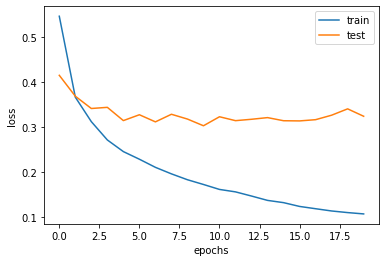

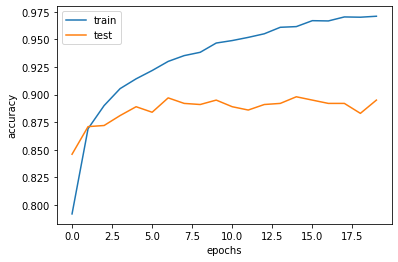

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

## 2- Added a single Dense layers on top of Xception

In [34]:
input_tensor = Input(shape=(102, 102, 3))

xception_model = xception.Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(xception_model.output)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=xception_model.input, outputs=predictions)

for layer in xception_model.layers:
    layer.trainable = False

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 102, 102, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 50, 50, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 50, 50, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 50, 50, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [35]:
model.compile(optimizer=Adam(lr=0.001), 
               loss=tf.keras.losses.sparse_categorical_crossentropy, 
               metrics=["accuracy"])

start_time = time.time()

history = model.fit(train_ds, epochs=20, validation_data=val_ds)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/20
250/250 [==============================] - 16s 64ms/step - loss: 0.5374 - accuracy: 0.8180 - val_loss: 0.3633 - val_accuracy: 0.8710
Epoch 2/20
250/250 [==============================] - 5s 22ms/step - loss: 0.2809 - accuracy: 0.9005 - val_loss: 0.3956 - val_accuracy: 0.8610
Epoch 3/20
250/250 [==============================] - 5s 21ms/step - loss: 0.2012 - accuracy: 0.9289 - val_loss: 0.3489 - val_accuracy: 0.8880
Epoch 4/20
250/250 [==============================] - 5s 22ms/step - loss: 0.1508 - accuracy: 0.9494 - val_loss: 0.3804 - val_accuracy: 0.8740
Epoch 5/20
250/250 [==============================] - 5s 22ms/step - loss: 0.1238 - accuracy: 0.9584 - val_loss: 0.5535 - val_accuracy: 0.8530
Epoch 6/20
250/250 [==============================] - 5s 22ms/step - loss: 0.1027 - accuracy: 0.9645 - val_loss: 0.3679 - val_accuracy: 0.8850
Epoch 7/20
250/250 [==============================] - 5s 22ms/step - loss: 0.0818 - accuracy: 0.9740 - val_loss: 0.4420 - val_accuracy: 0.879

In [44]:

y_pred = model.predict(test_ds)

# calculate classification accuracy
report = classification_report(y_test, np.argmax(y_pred, axis=1), target_names=class_names, digits=4)
print(report)


              precision    recall  f1-score   support

       Boots     0.9442    0.9480    0.9461       250
     Sandals     0.9310    0.8640    0.8963       250
       Shoes     0.8193    0.8160    0.8176       250
    Slippers     0.8433    0.9040    0.8726       250

    accuracy                         0.8830      1000
   macro avg     0.8845    0.8830    0.8831      1000
weighted avg     0.8845    0.8830    0.8831      1000



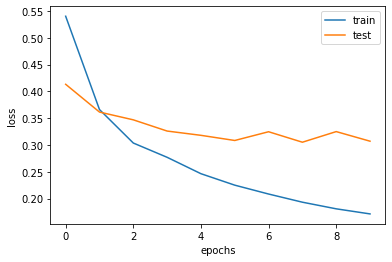

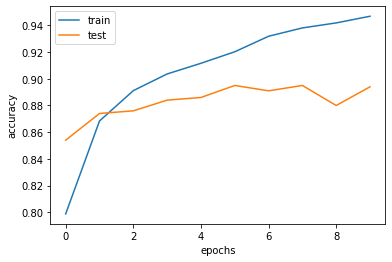

In [45]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [ ]:
######## OLD ###########

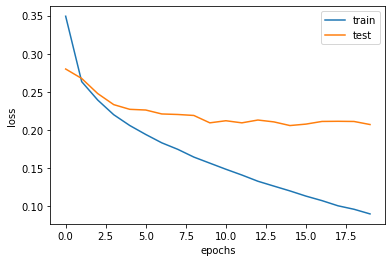

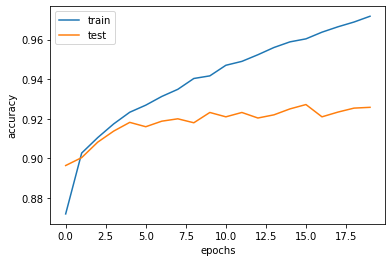

In [13]:
from matplotlib import pyplot

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

## 3- Train All Layers

In [62]:
input_tensor = Input(shape=(102, 102, 3))

xception_model = xception.Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(xception_model.output)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=xception_model.input, outputs=predictions)

for layer in xception_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(lr=0.001), 
               loss=tf.keras.losses.sparse_categorical_crossentropy, 
               metrics=["accuracy"],)

start_time = time.time()

history = model.fit(train_ds, epochs=20, validation_data=val_ds)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/20
250/250 [==============================] - 21s 86ms/step - loss: 0.3677 - accuracy: 0.8720 - val_loss: 0.6850 - val_accuracy: 0.8250
Epoch 2/20
250/250 [==============================] - 21s 83ms/step - loss: 0.1500 - accuracy: 0.9488 - val_loss: 0.3936 - val_accuracy: 0.8820
Epoch 3/20
250/250 [==============================] - 21s 83ms/step - loss: 0.1004 - accuracy: 0.9650 - val_loss: 0.3224 - val_accuracy: 0.9100
Epoch 4/20
250/250 [==============================] - 21s 83ms/step - loss: 0.0718 - accuracy: 0.9751 - val_loss: 0.1963 - val_accuracy: 0.9560
Epoch 5/20
250/250 [==============================] - 21s 83ms/step - loss: 0.0575 - accuracy: 0.9794 - val_loss: 0.1975 - val_accuracy: 0.9510
Epoch 6/20
250/250 [==============================] - 21s 83ms/step - loss: 0.0504 - accuracy: 0.9837 - val_loss: 0.7577 - val_accuracy: 0.8230
Epoch 7/20
250/250 [==============================] - 21s 83ms/step - loss: 0.0400 - accuracy: 0.9870 - val_loss: 0.2530 - val_accuracy:

In [65]:
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 102, 102, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 50, 50, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 50, 50, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 50, 50, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________

In [63]:

y_pred = model.predict(test_ds)

# calculate classification accuracy
report = classification_report(y_test, np.argmax(y_pred, axis=1), target_names=class_names, digits=4)
print(report)


              precision    recall  f1-score   support

       Boots     0.9356    0.9880    0.9611       250
     Sandals     0.9720    0.9720    0.9720       250
       Shoes     0.9355    0.9280    0.9317       250
    Slippers     0.9622    0.9160    0.9385       250

    accuracy                         0.9510      1000
   macro avg     0.9513    0.9510    0.9508      1000
weighted avg     0.9513    0.9510    0.9508      1000



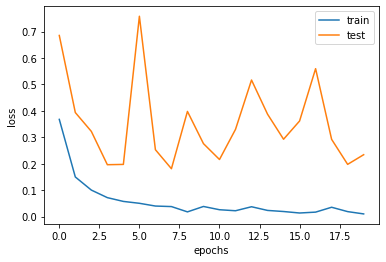

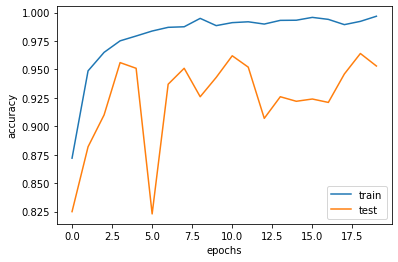

In [64]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

# References
- https://keras.io/api/applications/